In [ ]:
import os
import json
import random
import copy
from collections import defaultdict
from tqdm.notebook import tqdm,trange

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
# import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import evaluate

# import google.generativeai as genai
from google import genai
from json_repair import repair_json


class SudoArgs:
    exist = None

client = genai.Client(api_key="Your Gemini API Key")

## Ideation from human-written elements

In [ ]:
# import the concept discs: A.json, B.json, C.json and prompt.json in with a helper function

import json

def import_concept_discs(path):
    # research theme
    with open(path + 'A.json', 'r') as f:
        As = json.load(f)

    # research domain
    with open(path + 'B.json', 'r') as f:
        Bs = json.load(f)

    # research architecture
    with open(path + 'C.json', 'r') as f:
        Cs = json.load(f)

    with open(path + 'prompt.json', 'r') as f:
        prompts = json.load(f)

    with open(path + 'temp.json', 'r') as f:
        temps = json.load(f)

    return As, Bs, Cs, prompts, temps

path = './resource/seed/'
As, Bs, Cs, prompts, temps = import_concept_discs(path)

# print(As)
# print(Bs)
# print(Cs)
# print(prompts)
# print(temps)

In [3]:
# load the gemini client and generate content

def gen_with_gemini(client, prompt,max_tokens=1024):
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=prompt,
        config=genai.types.GenerateContentConfig(
            candidate_count=1,
            max_output_tokens=max_tokens,
            temperature=0.7,
        )
    )

    # print(response.candidates[0].content.parts[0].text)
    candidates = [cand.content.parts[0].text for cand in response.candidates]
    return candidates


# trial run with a prompt
# prompt = "What is the capital of France?"
# response = gen_with_gemini(client, prompt)
# print(response)



In [4]:
# Spinning up the gemini client

# safe save the response to folder named ./response/
# the response is a json object with the following keys:  combination, prompt, response
def save_response(response, folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # if the response name exist, add a number to the end
    if os.path.exists(folder_name + '/response.txt'):
        i = 1
        while os.path.exists(folder_name + '/response_' + str(i) + '.txt'):
            i += 1
        folder_name = folder_name + '/response_' + str(i) + '.txt'
    else:
        folder_name = folder_name + '/response.txt'

    with open(folder_name, 'w') as f:
        json.dump(response, f)

def main(As, Bs, Cs, prompts, templates, gemini_client):

    # random sample one or two words from theme, domain, and architecture
    # read the template, count how many Ax, Bx, Cx in the template
    # replace the Ax, Bx, Cx with the randomly selected words from the disc
    this_template = copy.deepcopy(templates[0])

    mapping = {"A": As, "B": Bs, "C": Cs}
    for i in range(3):
        for keyword in ["A", "B", "C"]:
            this_word = keyword + str(i)
            if this_word in this_template:
                random.seed(args.seed+i)
                chosen = random.choice(mapping[keyword])
                this_template = this_template.replace(this_word, random.choice(chosen))

    print("Combined concepts in a template: ", this_template)

    # generate a prompt
    prompt = prompts[0].replace("<combination>", this_template)
    print("Prompt: ", prompt)

    # generate a response
    if not args.generate:
        return prompt
    else:
        response = gen_with_gemini(gemini_client, prompt)

        folder_name = "./response/"
        output_json = {"combination": this_template, "template": templates[0], "prompt": prompt, "response": response}
        save_response(response, folder_name)

        return response

args = SudoArgs()
args.generate = False
args.seed = 2077

# response = main(As, Bs, Cs, prompts, temps, client)
# print(response)


## Visualization of elements mined from previous conferences

In [5]:
thinking_machine = {}
# load from ./resource/all_thinking_machine.json
for conf in ["iclr2024","colm2024","colt2024","acl2024","acl2023","acl2022","all"]:
    with open(f"./resource/{conf}_thinking_machine.json", "r") as f:
        thinking_machine[conf] = json.load(f)

# thinking_machine = raw_thinking_machine

for k in thinking_machine[conf].keys():
    print(k, end=" & ")
    for conf in ["iclr2024","colm2024","colt2024","acl2024","acl2023","acl2022","all"]:
        print(len(thinking_machine[conf][k]), end=" & ")

    print()

print(thinking_machine["all"]["A"])


A & 391 & 118 & 91 & 307 & 359 & 224 & 682 & 
B & 330 & 87 & 62 & 300 & 272 & 208 & 633 & 
C & 392 & 35 & 53 & 54 & 117 & 153 & 866 & 
Template & 278 & 71 & 75 & 121 & 277 & 165 & 925 & 
{'In-Context Learning': ['in-context learning'], 'Few-Shot Learning': ['few-shot'], 'In-the-Wild': ['in-the-wild'], 'Zero-Shot Learning': ['zero-shot'], 'Granularity': ['granularity', 'fine-grained', 'multi-granularity'], 'Long-Tail Learning': ['long-tail'], 'Compositionality': ['compositionality'], 'Generalization': ['generalization', 'domain generalization', 'generalizable', 'generalizability', 'domain-agnostic', 'temporal generalization', 'transferrable'], 'Self-Supervised Learning': ['self-', 'self-refine', 'self-evolve', 'self-supervised', 'self-training', 'self-distillation', 'self-learning', 'self-consistent', 'self-augment', 'self-correction', 'self-play'], 'Multi-Hop Reasoning': ['multi-hop'], 'Low-Resource Learning': ['low-resource', 'low resource', 'data-scarce'], 'Adaptive Learning': ['adap

In [6]:
# Analysis over the thinking machine topics with t-SNE

def visualize_a_conf_thinking_machine(thinking_machine, confs):
    text_data = []

    for conf in confs:
        for a in list(thinking_machine[conf]["A"].keys())[:20]:
            for b in list(thinking_machine[conf]["B"].keys())[:20]:
                for c in list(thinking_machine[conf]["C"].keys())[:20]:
                    # texts[conf].append(f"{a} {b} {c}")
                    text_data.append((f"{a} {b} {c}", conf))

    # Separate texts and labels
    texts = [item[0] for item in text_data]
    categories = [item[1] for item in text_data]

    # TF-IDF
    vectorizer = TfidfVectorizer(
        max_features=1000,
        stop_words='english',
        ngram_range=(1, 2)
    )

    tfidf_matrix = vectorizer.fit_transform(texts)

    # t-SNE
    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=min(30, len(texts)-1),
        # n_iter=1000,
        metric='cosine'
    )

    tsne_result = tsne.fit_transform(tfidf_matrix.toarray())

    # Create DataFrame for easier plotting
    return tsne_result
    
# tsne_result = visualize_a_conf_thinking_machine(thinking_machine, ["iclr2024","acl2024","colt2024","colm2024","acl2023","acl2022"])

Generated 48000 text entries for heatmap
t-SNE result shape: (48000, 2)


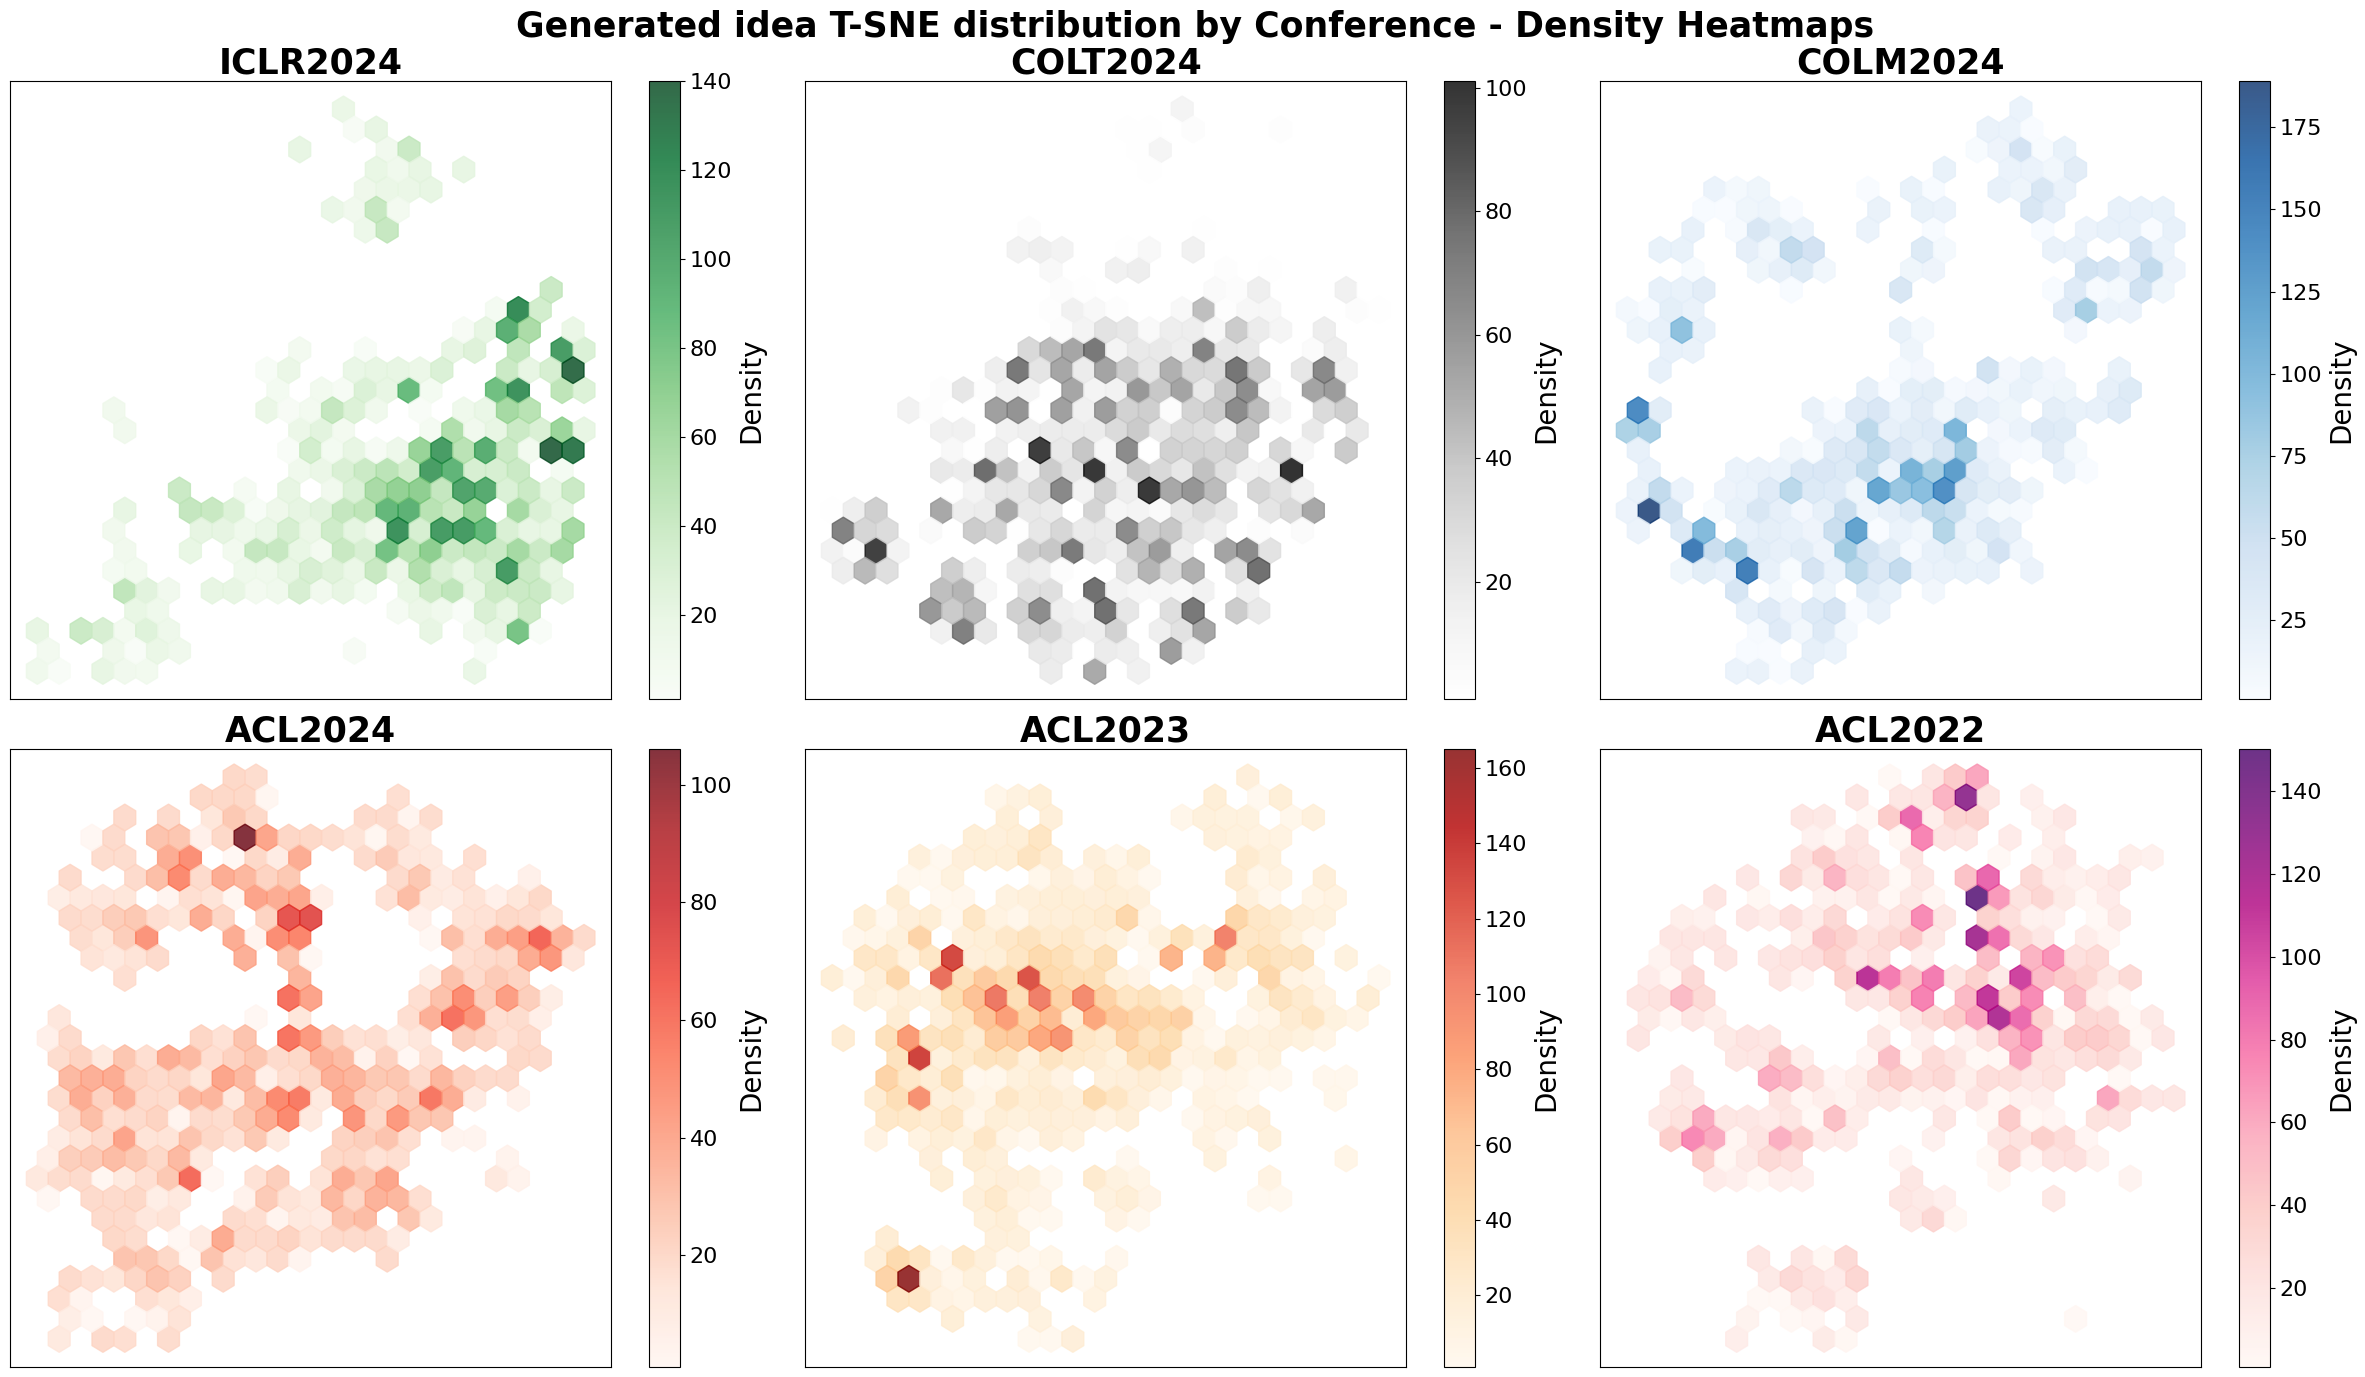

In [7]:


# Load your data
with open('./resource/tsne_result_20_all.json', 'r', encoding='utf-8') as f:
    tsne_result = json.load(f)

def create_heatmap_visualization(tsne_result, thinking_machine):
    """
    Clean heatmap visualization with slightly different reds for ACL conferences
    """
    text_data = []
    tsne_result = np.array(tsne_result)

    confs = ["iclr2024", "acl2024", "colt2024", "colm2024", "acl2023", "acl2022"]

    # Generate text data with proper error handling
    for conf in confs:
        if conf not in thinking_machine:
            print(f"Warning: {conf} not found in thinking_machine data")
            continue
            
        conf_data = thinking_machine[conf]
        
        # Check if the expected structure exists
        if not all(key in conf_data for key in ["A", "B", "C"]):
            print(f"Warning: {conf} missing required keys A, B, or C")
            continue
        
        # Get available keys and limit to 20 each
        a_keys = list(conf_data["A"].keys())[:20] if conf_data["A"] else []
        b_keys = list(conf_data["B"].keys())[:20] if conf_data["B"] else []  
        c_keys = list(conf_data["C"].keys())[:20] if conf_data["C"] else []
        
        # Generate combinations
        for a in a_keys:
            for b in b_keys:
                for c in c_keys:
                    text_data.append((f"{a} {b} {c}", conf.upper()))

    print(f"Generated {len(text_data)} text entries for heatmap")
    print(f"t-SNE result shape: {tsne_result.shape}")
    
    # Verify lengths match
    if len(text_data) != len(tsne_result):
        print(f"Error: Mismatch between text_data length ({len(text_data)}) and tsne_result length ({len(tsne_result)})")
        # Truncate to match the shorter length
        min_length = min(len(text_data), len(tsne_result))
        text_data = text_data[:min_length]
        tsne_result = tsne_result[:min_length]
        print(f"Truncated both to length: {min_length}")

    texts = [item[0] for item in text_data]
    categories = [item[1] for item in text_data]

    df = pd.DataFrame({
        'x': tsne_result[:, 0],
        'y': tsne_result[:, 1],
        'category': categories,
        'text': texts
    })

    # Create subplots for each conference (2x3 grid)
    fig, axes = plt.subplots(2, 3, figsize=(24, 14))
    axes = axes.flatten()
    
    # Define the order: top row (ICLR, COLT, COLM), bottom row (ACL 2024, 2023, 2022)
    categories_ordered = ["ICLR2024", "COLT2024", "COLM2024", "ACL2024", "ACL2023", "ACL2022"]
    
    # Different red variants for ACL conferences
    conf_colormaps = {
        "ICLR2024": "Greens",
        "COLT2024": "Greys", 
        "COLM2024": "Blues",
        "ACL2024": "Reds",      # Standard reds
        "ACL2023": "OrRd",      # Orange-reds
        "ACL2022": "RdPu"       # Red-purple (cleaner than YlOrRd)
    }
    
    for i, category in enumerate(categories_ordered):
        ax = axes[i]
        
        if category not in df['category'].unique():
            ax.set_visible(False)
            continue
            
        category_data = df[df['category'] == category]
        
        if len(category_data) == 0:
            ax.set_visible(False)
            continue
        
        # Create hexbin plot for density
        # make the numbers in the hexbin larger and the colorbar smaller
        hb = ax.hexbin(category_data['x'], category_data['y'], 
                      gridsize=25, cmap=conf_colormaps[category], alpha=0.8, mincnt=1)
        
        ax.set_title(f'{category}', fontsize=25, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add colorbar
        cb = plt.colorbar(hb, ax=ax)
        cb.set_label('Density', fontsize=20)
        cb.ax.tick_params(labelsize=16)
    
    plt.suptitle('Generated idea T-SNE distribution by Conference - Density Heatmaps', fontsize=25, fontweight='bold')
    plt.tight_layout()
    
    plt.savefig('./assets/tsne_heatmap_final.pdf', 
                format='pdf', dpi=700, bbox_inches='tight')
    plt.show()

# Usage
create_heatmap_visualization(tsne_result, thinking_machine)

## Generating idea titles and compare with previous work

In [ ]:
# generate ramon llull thinking machine
with open("./resource/acl2024_thinking_machine.json", "r") as f:
    thinking_machine = json.load(f)

# print(list(thinking_machine["A"].keys())[:5])
# print(list(thinking_machine["B"].keys())[:5])
# print(list(thinking_machine["C"].keys())[:5])


def generate_ramon_titles(prompt, thinking_machine, metric="diversity"):
    As = list(thinking_machine["A"].keys())
    Bs = list(thinking_machine["B"].keys())
    Cs = list(thinking_machine["C"].keys())

    # random sample 5 As, Bs, Cs with a seed
    # random.seed(42)
    # As = random.sample(As, 5)
    # Bs = random.sample(Bs, 5)
    # Cs = random.sample(Cs, 5)

    print(As, Bs, Cs)

    ramon_ideas, all_combinations = [], []

    if metric == "diversity":
        for i in range(100):
            a, b, c = As[i%54], Bs[i%54], Cs[i%54]
            combination = f"{a}, {b}, {c}"
            all_combinations.append(combination)
    elif metric == "relevance":
        for a in As[:5]:
            for b in Bs[:5]:
                for c in Cs[:4]:
                    combination = f"{a}, {b}, {c}"
                    all_combinations.append(combination)
    elif metric == "random":
        for i in range(100):
            random.seed(42+i)
            a, b, c = random.choice(As), random.choice(Bs), random.choice(Cs)
            combination = f"{a}, {b}, {c}"
            all_combinations.append(combination)

    elif metric == "random-relevance":
        As = As[:10]
        Bs = Bs[:10]
        Cs = Cs[:10]

        for i in range(100):
            random.seed(42+i)
            a = random.choice(As)
            random.seed(42+i+1)
            b = random.choice(Bs)
            random.seed(42+i+2)
            c = random.choice(Cs)
            combination = f"{a}, {b}, {c}"
            all_combinations.append(combination)
    else:
        print("Invalid metric")

    for combination in tqdm(all_combinations):
        prompt="You are a senior professor in AI and your students propose to do <combination>.Can you refine the title into a good one that can be accepted by top conferences such as ACL 2025 and ICLR 2026? Please output one tilte only, with no other text. \n\n Requirements: 1. do not hallucinate, 2. do not use any existing paper names in your pretraining data. 3. make sure the title and outline is with an outstanding paper quality so that your student can be happy and successfully graduate."

        prompt = prompt.replace("<combination>", combination)
        # print(prompt)
        response = gen_with_gemini(client, prompt)
        ramon_ideas.append(response)

    return ramon_ideas

# relevnace is the top row in table 5 in the paper

# ramon_ideas = generate_ramon_titles(prompt, thinking_machine, metric="relevance")
# print(ramon_ideas)
            


In [ ]:
# read the previous papers

def read_previous_ideation_main():

    # number of ideas: aiscientist: 93, research_town: 1000
    idea_collection = {"ai_scientist":{}, "research_town":{}, "acl2025":{"main":[]}}

    # read ai scientist ideas
    path = './resource/literature_ideas/ai_scientist/'
    folders = ["AI_AI_Ideas_Processed","AI_Human_Ideas_Txt"]

    for folder in folders:
        idea_collection["ai_scientist"][folder] = []
        for file in os.listdir(path + folder):
            with open(path + folder + '/' + file, 'r') as f:
                lines = f.readlines()
                # print(lines[0])
                idea_collection["ai_scientist"][folder].append(lines[0].replace("Title: ", "").replace("\n", ""))

    for k,v in idea_collection["ai_scientist"].items():
        print(k,len(v))

    # read research town ideas
    path = './resource/literature_ideas/research_town/'
    folders = ["none"] #"author_paper","none","paper"
    for folder in folders:
        idea_collection["research_town"][folder] = []
        for file in os.listdir(path + folder):
            if "gpt" not in file:
                continue
            temp = pd.read_csv(path + folder + '/' + file)
            rows = temp["gen"]
            for row in rows:
                line = row.split("[Question 2]")[0].split("[Question 1]")[-1]
                line = line.split("\n")[1].strip()
                line = line.replace("- What is the problem?","").strip()
                idea_collection["research_town"][folder].append(line)

                if len(idea_collection["research_town"][folder]) >= 100:
                    break

    for k,v in idea_collection["research_town"].items():
        print(k,len(v))

    path = "./resource/literature_ideas/acl2025_raw.txt"
    with open(path, 'r') as f:
        lines = f.readlines()
        for i,line in enumerate(lines):
            if i%2 == 0:
                line = line.strip()
                if line:
                    idea_collection["acl2025"]["main"].append(line)
    print("ACL2025 main:",len(idea_collection["acl2025"]["main"]))

    return idea_collection

# idea_collection = read_previous_ideation_main()
# idea_collection["ramon"]={}
# idea_collection["ramon"]["top"] = [idea[0].replace("Title: ", "").replace("\n", "").strip() for idea in ramon_ideas]


In [ ]:
# load reference acl paper titles

def jaccard_coverage(title1, title2):
    tokens1 = set(title1.lower().split())
    tokens2 = set(title2.lower().split())
    intersection = tokens1.intersection(tokens2)
    union = tokens1.union(tokens2)
    return len(intersection) / len(union) if union else 0

def eval_ideas(idea_collection):
    bleu = evaluate.load("bleu")

    score_collection = {}
    eval_dataset_names = ["ramon"] #"ai_scientist","research_town",
    for name in eval_dataset_names:
        score_collection[name] = {}

    # metrics
    for name in eval_dataset_names:
        print("We are evaluating the ideas in", name)
        all_ideas = []
        for k,v in idea_collection[name].items():
            all_ideas.extend(v)

        # compute the number of words
        sum_words = sum([len(idea.split(" ")) for idea in all_ideas])
        score_collection[name]["num_words"] = sum_words

        # compute the number of normalized unigram count
        tokens = []
        for idea in all_ideas:
            temp_tokens = [token.lower() for token in idea.split(" ")]
            for tok in temp_tokens:
                if tok not in tokens:
                    tokens.append(tok)
        
        score_collection[name]["diversity"] = len(tokens)/sum_words

        # relevance - bleu score with reference
        references = [idea_collection["acl2025"]["main"]]
        bleu_scores = []
        for idea in tqdm(all_ideas):
            score = bleu.compute(predictions=[idea], references=references)
            bleu_scores.append(score["bleu"])

        score_collection[name]["relevance"] = sum(bleu_scores)/len(bleu_scores)

        # coverage - average of the top-100 jaccard similarity with reference
        jaccard_scores = []
        references = idea_collection["acl2025"]["main"]
        for idea in all_ideas:
            temp_scores = []
            for ref in references:
                temp_scores.append(jaccard_coverage(idea, ref))
            jaccard_scores.append(max(temp_scores))
        top_k = len(all_ideas)
        # select the top-k jaccard scores
        sorted_jaccard_scores = sorted(jaccard_scores, reverse=True)
        score_collection[name]["coverage"] = sum(sorted_jaccard_scores[:top_k])/top_k

    print(score_collection)

    return score_collection

# score_collection = eval_ideas(idea_collection)

## Final Remark
Thank you for reading the code. Please contact the authors for (1) code for mining the ideas from conferences; (2) ideas generated in previous work.